In [1]:
# Imports
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import joblib

In [2]:
# Chargement des données
root_folder = "C:/Users/user/Downloads/SESA/data"

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Mel-frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000), ref=np.max)
    delta_mfcc = librosa.feature.delta(mfccs)

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Spectral centroid : brightness of sound
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # Bandwidth : Spread of frequencies around the centroid
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    # Rolloff : Frequency below which a certain % of the total spectral energy lies
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    # Flatness : Tonal vs. noisy quality (close to 1: noisy)
    flatness = librosa.feature.spectral_flatness(y=y)

    # Contrast : Difference in energy between peaks and valleys in spectrum
    contrast = librosa.feature.spectral_contrast(y=y)
    
    # RMS energy
    rms = librosa.feature.rms(y=y)

    # tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    

    return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), zcr.std(), zcr.mean(), centroid.mean(), centroid.std(), rms.mean(), rms.std(),
                      bandwidth.mean(), bandwidth.std(), rolloff.mean(), rolloff.std(), flatness.mean(), flatness.std(), tempo,
                      contrast.mean(), contrast.std(), delta_mfcc.mean(axis=1), mel_spec.mean(), mel_spec.std(), duration])

In [3]:
from tqdm import tqdm
# Train set
X_train = []
y_train = []
train_path = root_folder + '/' + 'train'
lof_train = [f for f in listdir(train_path)]
for file in tqdm(lof_train):
    if file.lower().endswith('.wav'):
        wav_path = train_path + '/' + file
        #print(f"Processing {file}...")

        try:
            feats = extract_features(wav_path)
            X_train.append(feats)
            label = file.split("_")[0]
            y_train.append(label)
        except Exception as e:
            print(f"Erreur sur {fname}: {e}")

 35%|███▌      | 170/480 [00:31<00:35,  8.66it/s]c:\Users\user\Downloads\SESA\.venv\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 480/480 [01:11<00:00,  6.75it/s]


In [4]:
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-214.139328,85.231926,7.754147,20.030664,8.435097,-1.148879,-1.674291,2.449226,-3.082518,-2.504000,...,-0.119795,-0.029765,-0.125059,-0.069766,-0.033784,-0.046760,-0.030268,-49.888966,12.919282,4.063500
1,-182.669891,139.957489,-13.008949,-9.594439,2.268462,-8.228940,-3.368181,-3.799409,-6.904059,-3.342158,...,-0.044827,-0.007705,0.040634,0.044949,0.001905,-0.011398,-0.046884,-38.650909,13.752724,5.107000
2,-208.489929,153.425247,27.717066,-7.101077,3.268686,1.448832,-0.675364,0.723373,-2.197042,-5.230395,...,0.023531,0.037053,0.035425,0.024394,-0.008133,-0.023841,0.011577,-46.627377,14.736822,5.822750
3,-144.941574,117.532486,-0.449676,17.386435,-2.250551,7.353186,-3.068521,3.168828,-1.312694,5.112125,...,0.034639,0.045051,0.043404,0.153599,0.147008,0.055529,0.019574,-45.432278,13.399794,3.443313
4,-193.035004,133.166901,21.552776,12.347239,10.635363,11.406835,0.431604,1.365485,-1.240355,1.622149,...,-0.067002,-0.070194,0.023398,0.068471,0.038521,0.045514,0.078193,-43.331070,12.966900,2.863000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-177.370667,58.329281,-16.320314,44.719917,-19.990864,-29.236916,4.663920,7.354265,-12.078789,-2.650355,...,0.010430,-0.020872,0.000473,0.005277,0.013048,0.022574,0.026252,-33.819256,11.363682,17.844562
476,-127.919083,-2.386326,-100.990311,-10.497728,-39.396351,17.145721,10.154982,21.286140,-6.785413,15.749054,...,-0.001303,0.003108,0.000289,-0.003982,0.000198,0.004970,0.005595,-42.277294,17.133659,17.166438
477,-188.819656,54.939171,-25.648821,-0.949367,-16.657108,-5.479622,-9.296740,6.340583,7.877621,27.045076,...,-0.015864,0.016688,0.014317,-0.001100,-0.014905,-0.001644,-0.002646,-40.797626,12.081903,9.357000
478,-248.646072,2.169747,-28.063004,-0.974340,-13.223262,0.105991,-8.894626,-2.588324,-6.156933,-1.077065,...,-0.005845,0.007878,-0.021128,-0.011025,0.002076,0.002379,-0.006285,-41.518448,12.479364,8.340625


In [5]:
len(y_train)

480

In [6]:
# Test set
X_test = []
y_test = []
test_path = root_folder + '/' + 'test'
lof_test = [f for f in listdir(test_path)]
for file in tqdm(lof_test):
    if file.lower().endswith('.wav'):
        wav_path = test_path + '/' + file
        #print(f"Processing {file}...")

        try:
            feats = extract_features(wav_path)
            X_test.append(feats)
            label = file.split("_")[0]
            y_test.append(label)
        except Exception as e:
            print(f"Erreur sur {fname}: {e}")

 35%|███▌      | 37/105 [00:05<00:07,  9.51it/s]c:\Users\user\Downloads\SESA\.venv\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 105/105 [00:14<00:00,  7.36it/s]


In [7]:
X_test = pd.DataFrame(X_test)
X_test

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-285.336853,39.557961,6.823731,-6.991809,-2.231251,-5.570866,4.142883,1.919463,2.996999,3.828701,...,0.030656,0.032032,0.091915,0.053156,0.026597,-0.051901,-0.037753,-51.661217,12.409604,2.594187
1,-202.148529,125.430786,22.815258,16.928595,7.827446,10.610357,1.928356,0.797735,-1.971050,-0.569811,...,0.018325,-0.006443,0.043370,0.013914,0.019856,0.021485,0.047405,-45.823547,13.620205,7.737875
2,-274.326050,87.713692,22.296471,12.046974,9.290386,0.227976,-1.534712,-2.058927,0.810843,0.883053,...,-0.015152,-0.015826,0.006435,0.011468,0.006795,0.002756,-0.001828,-54.678429,12.350676,9.716062
3,-139.558014,96.290459,-12.715135,23.884241,3.912950,9.122540,-1.091687,1.826365,-3.864039,2.160678,...,-0.139853,0.003690,0.002028,0.010765,-0.106475,-0.050876,-0.027676,-37.998138,13.589693,3.715187
4,-278.747559,104.703293,49.921154,30.906958,12.577966,8.418180,5.877398,7.357359,5.469634,5.562014,...,-0.009055,0.022756,0.014032,-0.006471,0.005731,-0.000331,-0.002793,-52.535728,11.470143,11.749313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-265.904297,52.246677,-68.882263,-55.843246,-15.972671,11.794717,31.168846,11.064370,-10.932279,-3.095665,...,0.012035,0.171818,0.226510,-0.176995,-0.229938,0.083977,0.099201,-36.002419,11.199508,4.423375
101,-141.827957,-4.415758,-15.064084,15.997670,-6.823156,4.078452,-23.603327,4.172225,-6.441214,27.220316,...,-0.001562,0.002253,-0.010178,-0.008465,-0.013087,-0.009197,0.014743,-32.518616,10.351944,15.714438
102,-217.382385,34.357731,-21.979385,43.358074,-13.459932,-33.682705,10.395032,18.594257,-11.773409,-0.539092,...,-0.042231,0.006912,-0.008458,0.006716,-0.037079,-0.047891,-0.024864,-40.630932,11.532209,9.833625
103,-218.826126,-4.936053,-60.218437,-20.703886,-19.971292,58.685089,-7.173977,-10.568643,6.391278,4.351566,...,0.014228,-0.073055,-0.061069,0.012843,-0.000384,-0.015156,-0.018032,-56.047928,19.025322,4.098312


In [8]:
len(y_test)

105

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=1995)

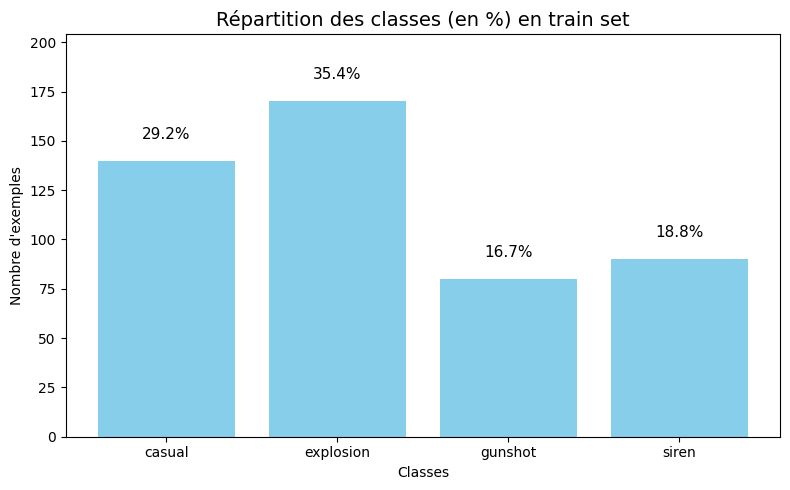

In [18]:
from collections import Counter
# Re-transformer les labels encodés
y_decoded = le.inverse_transform(y_encoded)

# Compter les classes
counter = Counter(y_decoded)
df_counts = pd.DataFrame.from_dict(counter, orient='index', columns=['Count']).sort_index()

# Calcul des pourcentages
total = df_counts['Count'].sum()
df_counts['Percentage'] = df_counts['Count'] / total * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_counts.index, df_counts['Count'], color='skyblue')

# Ajouter les pourcentages au-dessus de chaque barre
for bar, perc in zip(bars, df_counts['Percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + total * 0.02, f'{perc:.1f}%', 
            ha='center', va='bottom', fontsize=11)#, fontweight='bold')

# Ajustements visuels
ax.set_title("Répartition des classes (en %) en train set", fontsize=14)
ax.set_ylabel("Nombre d'exemples")
ax.set_xlabel("Classes")
plt.ylim(0, df_counts['Count'].max() * 1.2)  # espace au-dessus

plt.tight_layout()
plt.show()

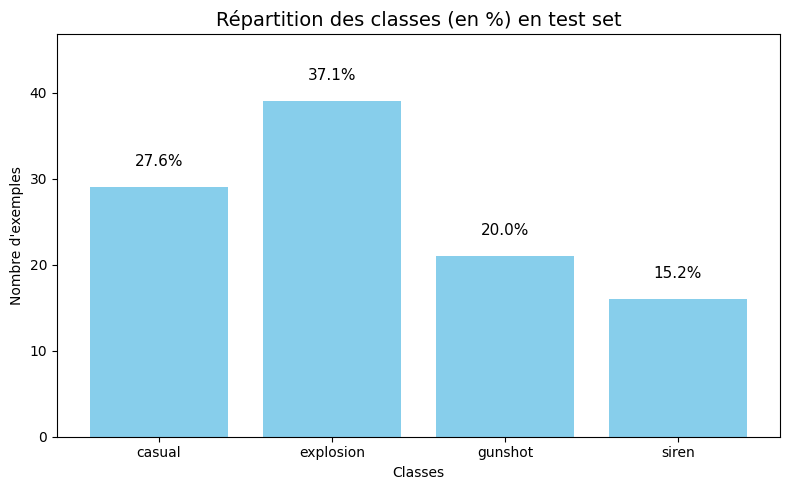

In [19]:
from collections import Counter
# Re-transformer les labels encodés
y_decoded = le.inverse_transform(y_test)

# Compter les classes
counter = Counter(y_decoded)
df_counts = pd.DataFrame.from_dict(counter, orient='index', columns=['Count']).sort_index()

# Calcul des pourcentages
total = df_counts['Count'].sum()
df_counts['Percentage'] = df_counts['Count'] / total * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_counts.index, df_counts['Count'], color='skyblue')

# Ajouter les pourcentages au-dessus de chaque barre
for bar, perc in zip(bars, df_counts['Percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + total * 0.02, f'{perc:.1f}%', 
            ha='center', va='bottom', fontsize=11)#, fontweight='bold')

# Ajustements visuels
ax.set_title("Répartition des classes (en %) en test set", fontsize=14)
ax.set_ylabel("Nombre d'exemples")
ax.set_xlabel("Classes")
plt.ylim(0, df_counts['Count'].max() * 1.2)  # espace au-dessus

plt.tight_layout()
plt.show()

In [10]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "SVM": SVC(kernel='rbf', probability=True, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, n_estimators=300, objective='multi:softmax', eval_metric='mlogloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    report = classification_report(y_val, y_pred, output_dict=True)

    results[name] = {
        "model": model,
        "report": report
    }

c:\Users\user\Downloads\SESA\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:15:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(pd.DataFrame(res["report"]).T[["precision", "recall", "f1-score"]])


=== RandomForest ===
              precision    recall  f1-score
0              0.833333  0.892857  0.862069
1              0.969697  0.941176  0.955224
2              1.000000  1.000000  1.000000
3              0.882353  0.833333  0.857143
accuracy       0.916667  0.916667  0.916667
macro avg      0.921346  0.916842  0.918609
weighted avg   0.918598  0.916667  0.917126

=== LogisticRegression ===
              precision    recall  f1-score
0              0.833333  0.892857  0.862069
1              0.911765  0.911765  0.911765
2              1.000000  1.000000  1.000000
3              0.875000  0.777778  0.823529
accuracy       0.895833  0.895833  0.895833
macro avg      0.905025  0.895600  0.899341
weighted avg   0.896701  0.895833  0.895432

=== SVM ===
              precision    recall  f1-score
0              0.866667  0.928571  0.896552
1              0.969697  0.941176  0.955224
2              1.000000  1.000000  1.000000
3              0.941176  0.888889  0.914286
accuracy     

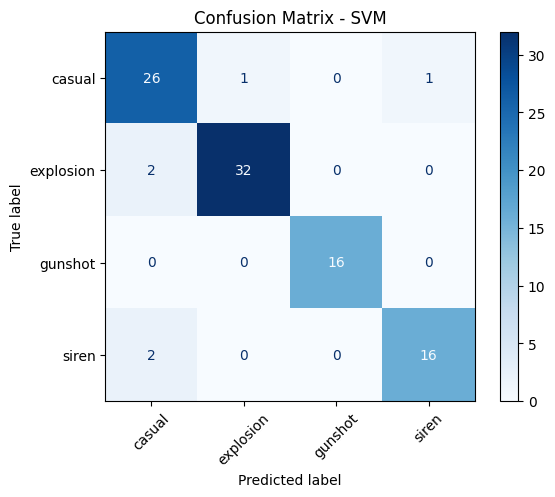

In [12]:
# Confusion matrix on validation set
from sklearn.metrics import ConfusionMatrixDisplay

best_model = results["SVM"]["model"]
y_pred = best_model.predict(X_val)
label_names = le.classes_

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=label_names, cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=45)
plt.show()

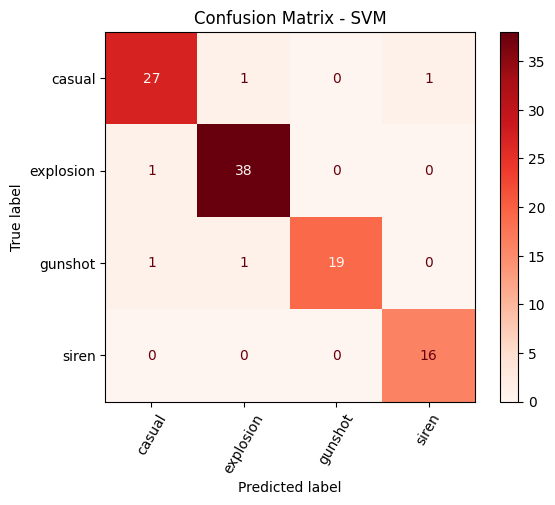

In [13]:
# Now we train the best model on the hole train dataset
best_model = models['SVM'].fit(X_scaled, y_encoded)

y_pred = best_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_names, cmap='Reds')
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=60)
plt.show()

In [31]:
joblib.dump(best_model, "best_multiclass_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
results = {}

# Isolation Forest
print("_____________________________")
print(" --  Isolation Forest -- ")
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train)
y_pred = iso.predict(X_val)
y_pred = np.where(y_pred == -1, 1, 0)
results["IsolationForest"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_val, y_pred)
}
print("_____________________________")
print("\n")

# One-Class SVM
print("_____________________________")
print(" --  One-Class SVM -- ")
svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
svm.fit(X_train)
y_pred = svm.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)
results["OneClassSVM"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_test, y_pred)
}
print("_____________________________")
print("\n")

# Local Outlier Factor (unsupervised, fit + predict sur test)
print("_____________________________")
print(" --  Isolation Forest -- ")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)
results["LOF"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_test, y_pred)
}
print("_____________________________")
print("\n")

# RandomForest (supervised, si labels fiables)
print("_____________________________")
print(" --  Isolation Forest -- ")
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results["RandomForest"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_test, y_pred)
}
print("_____________________________")
print("\n")